Plot the EMA trajectories of a participant, the time points of EMI delivery/input selection, and the empirical and predicted effects of the inputs given the optimal control, brute force, or max AC strategy

In [15]:
strategy = 'max AC'
subject = 9

Load data or create random dataset

In [16]:
from ctrl import utils

d = utils.load_data()[subject]
# d = utils.generate_random_dataset(1, 50)[0]

100%|██████████| 25/25 [00:00<00:00, 109.48it/s]


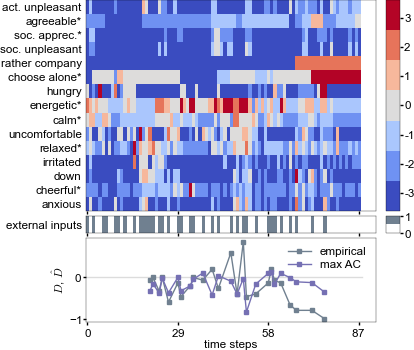

In [17]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp
from tqdm import tqdm
import ctrl.discrete_optimal_control as doc
import ctrl.control_strategies as strategies
from custom_rcparams_paper import colors


T = len(d['X'])
n_inp = d['Inp'].shape[1]
n_emas = d['X'].shape[1]
Yref = np.ones(n_emas) * (-3)
rho = 80
Q = np.eye(n_emas)
R = np.eye(n_inp) * rho
select_from = np.eye(n_inp)
    
EMI_times = np.where(d['Inp'].sum(axis=1) > 0)[0]
if EMI_times[-1] >= len(d['Inp'])-1:
    EMI_times = EMI_times[:-1]
EMI_times = EMI_times[EMI_times>=20]

effects = pd.DataFrame(index=EMI_times, columns=['empirical', 'controlled'])
effects['empirical'] = (d['X'][EMI_times + 1] - d['X'][EMI_times]).mean(axis=1)

X_ctrl = np.zeros((T, n_emas))
U = np.zeros((T, n_inp))
for t in tqdm(EMI_times):
    if strategy == 'optimal ctrl':
        try:
            U[t] = strategies.optimal_control_strategy(d['X'][:t+1], d['Inp'][:t+1], Yref, select_from, rho, online=True)
        except:
            print(f'error in subject {i} at time {t}')
            X_ctrl[t] = np.nan
            U[t] = np.nan
    elif strategy == 'brute force':
        U[t] = strategies.brute_force_strategy(d['X'][:t+1], d['Inp'][:t+1], Yref, select_from, 5, rho, online=True)
    elif strategy == 'max AC':
        U[t] = strategies.max_ac_strategy(d['X'][:t+1], d['Inp'][:t+1], select_from, online=True)
    X_ctrl[t] = doc.step(d['A'], d['B'], d['X'][t], U[t])
effects['controlled'] = (X_ctrl[EMI_times] - d['X'][EMI_times]).mean(axis=1)

fig, axes = plt.subplots(3, 1, figsize=(4, 3.5), height_ratios=(2.5,0.2,1), sharex=True)
_, cax = utils.colorplot_trajectory(d['X'], d['Xlabs'], aspect='auto', cmap=colors.likert_cmap, ax=axes[0])
axes[0].set(xlabel='')
cax.set(yticks=np.linspace(-2.5, 2.5, 7), yticklabels=np.linspace(-3,3,7, dtype=int))
utils.colorplot_trajectory(d['Inp'].any(axis=1, keepdims=True), ['external inputs'], cmap=colors.binary_cmap, ax=axes[1])
axes[1].set(xlabel='')
ghost_axis = utils.steal_space_from_axis(axes[2])
fig.delaxes(ghost_axis)
axes[2].plot((0, len(d['X'])), (0, 0), color=colors.lightgrey)
emp_hdl, = axes[2].plot(np.arange(len(d['X']))[EMI_times], effects.loc[EMI_times, 'empirical'], color=colors.standard,
    marker='s')
algo_hdl, = axes[2].plot(np.arange(len(d['X']))[EMI_times], effects.loc[EMI_times, 'controlled'], color=colors.algorithms_dict[strategy],
    marker='s')
axes[2].set(ylabel='$D$, $\hat{D}$', xlabel='time steps')
axes[2].legend(handles=[emp_hdl, algo_hdl], labels=['empirical', strategy])

plt.savefig(f'figures/3d.png', dpi=200)
